# Imports

In [1]:
from keras.datasets import mnist
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from numpy.linalg import norm

2022-11-10 22:05:31.070184: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Load data

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [3]:
x_train = x_train.astype(float) / 256
x_test = x_test.astype(float) / 256

# Visualise example

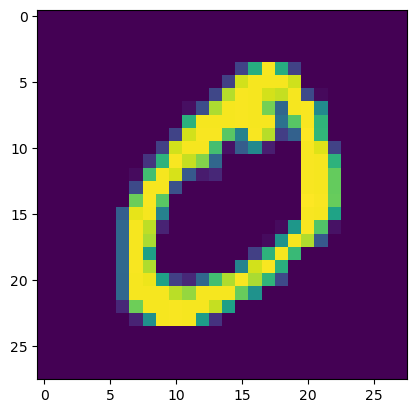

In [4]:
digit = x_train[1]
fig, ax = plt.subplots()
im = ax.imshow(digit)
plt.show()

# Some Preprocessing

In [5]:
def flatening_pictures(data):
    n = data.shape[0]
    flaten_data = []
    for i in range(n):
        picture = data[i]
        flaten_data.append(picture.flatten())
    return flaten_data


def row_to_matrix(row):
    matrix = []
    k = 0
    one_row = []
    for i in range(len(row)):
        one_row.append(row[i])
        k += 1
        if k == 28:
            k = 0
            matrix.append(one_row)
            one_row = []
    return matrix


def to_categorical(data):
    n = data.shape[0]
    Y_t = []
    for i in range(n):
        ans_digit = [0,0,0,0,0,0,0,0,0,0]
        ans_digit[data[i]] = 1
        Y_t.append(ans_digit)
    Y_t = np.array(Y_t)
    return Y_t


In [6]:
X_t = flatening_pictures(x_train)

In [7]:
Y_t = to_categorical(y_train)

[0 0 1 0 0 0 0 0 0 0]


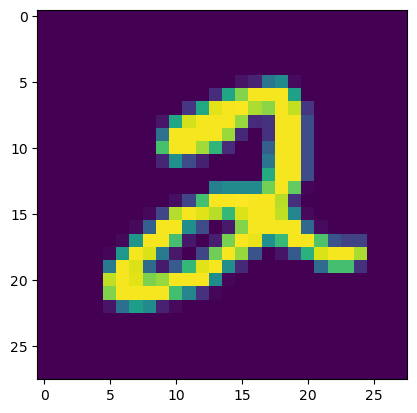

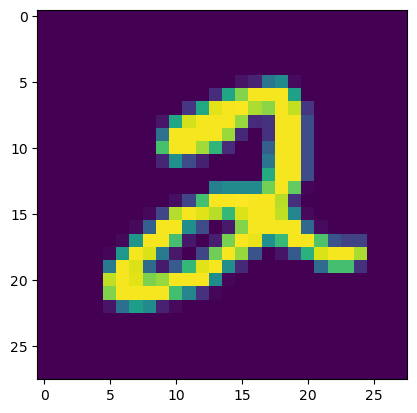

In [8]:
# check preprocessing results

print(Y_t[5])

fig, ax = plt.subplots()
im = ax.imshow(row_to_matrix(X_t[5]))
plt.show()

fig, ax = plt.subplots()
im = ax.imshow(x_train[5])
plt.show()

# One layer perceptron formulation

In [9]:
def sigmoid(x):
    """сигмоидальная функция, работает и с числами, и с векторами (поэлементно)"""
    return 1 / (1 + np.exp(-x))

def sigmoid_prime(x):
    """производная сигмоидальной функции, работает и с числами, и с векторами (поэлементно)"""
    return sigmoid(x) * (1 - sigmoid(x))

In [10]:
def J_quadratic(neuron, X, y):
    """
    Оценивает значение квадратичной целевой функции.
    Всё как в лекции, никаких хитростей.

    neuron - нейрон, у которого есть метод vectorized_forward_pass, предсказывающий значения на выборке X
    X - матрица входных активаций (n, m)
    y - вектор правильных ответов (n, 1)
        
    Возвращает значение J (число)
    """
    
    assert y.shape[1] == 1, 'Incorrect y shape'
    
    return 0.5 * np.mean((neuron.vectorized_forward_pass(X) - y) ** 2)

def J_quadratic_derivative(y, y_hat):
    """
    Вычисляет вектор частных производных целевой функции по каждому из предсказаний.
    y_hat - вертикальный вектор предсказаний,
    y - вертикальный вектор правильных ответов,
    
    В данном случае функция смехотворно простая, но если мы захотим поэкспериментировать 
    с целевыми функциями - полезно вынести эти вычисления в отдельный этап.
    
    Возвращает вектор значений производной целевой функции для каждого примера отдельно.
    """
    
    assert y_hat.shape == y.shape and y_hat.shape[1] == 1, 'Incorrect shapes'
    
    return (y_hat - y) / len(y)


In [11]:
class Neuron:
    
    def __init__(self, weights,costF,costF_deriv,activation_function, activation_function_derivative):
        self.costF = costF
        self.costF_deriv = costF_deriv
        self.w = weights
        self.activation_function = activation_function
        self.activation_function_derivative = activation_function_derivative
    
    def summatory(self, single_input):      
        result = 0
        for i in range(len(self.w)):
            result += float(self.w[i] * single_input[i])
        return result
   

In [12]:
class Network():
    def __init__(self,layers,activeF,activeF_deriv,costF,costF_deriv,learning_rate):
        self.lay_num = len(layers)
        self.NET = []
        self.activationsL = []
        self.costF = costF
        self.costF_deriv = costF_deriv
        self.activeF = activeF
        self.activeF_deriv = activeF_deriv
        self.deltas = []
        self.summatories = []
        self.deltas = []
        self.learning_rate = learning_rate
        for L in range(self.lay_num):
            layer = []
            for j in range(layers[L]):
                if L == 0:
                    layer.append(0)
                else:
                    m = layers[L-1] # сколько у нейрона входов (столько же сколько нейронов на предыдущем слое)
                    wnp = np.random.random((m, 1))*0.1
                    w = []
                    for i in range(wnp.size):
                        w.append(wnp[i][0])
                    N = Neuron(weights = w,costF=self.costF,costF_deriv=self.costF_deriv,activation_function=self.activeF, activation_function_derivative=self.activeF_deriv)
                    layer.append(N)
            self.NET.append(layer)
            self.deltas.append([])
            self.activationsL.append([])
            self.summatories.append([])
            self.deltas.append([])
        return
    
    def predict(self,x): # x'shape is row
        for L in range(0,self.lay_num):
            if L == 0:
                a = x
                z = [0]*len(self.NET[0])
            else:
                n_L = len(self.NET[L])
                a_prev = self.activationsL[L-1]
                a = []
                z = []
                for j in range(n_L):
                    s = self.NET[L][j].summatory(a_prev)
                    z.append(s)
                    a.append(self.activeF(s))
            self.activationsL[L] = a
            self.summatories[L] = z
        return 0            
    
    def delta_Last(self,y): # y'shape is (10,1)
        aLast = self.activationsL[self.lay_num-1]
        zLast = self.summatories[self.lay_num-1]
        aLast_np = np.array(aLast).reshape((len(aLast),1))
        zLast_np = np.array(zLast).reshape((len(zLast),1))
        return self.costF_deriv(y,aLast_np)*self.activeF_deriv(zLast_np)
    
    def peekUpDeltas(self,y):                
        self.deltas[0] = np.zeros((len(self.NET[0]),1))
        self.deltas[self.lay_num-1] = self.delta_Last(y)
        for L in range(self.lay_num-2,0,-1):
            z_L = np.array(self.summatories[L]).reshape((len(self.summatories[L]),1))
            d_lp1 = self.deltas[L+1]
            u = len(self.NET[L+1])
            y = len(self.NET[L])
            w_front = np.zeros((u,y))
            for k in range(0,u):
                for j in range(0,y):
                    w_front[k][j] = self.NET[L][k].w[j].copy()
            self.deltas[L] = w_front.T.dot(d_lp1) * self.activeF_deriv(z_L)
        return 0
    
    def trainOnSingleExample(self,x,y):
        self.predict(x)
        self.peekUpDeltas(y)
        for L in range(1,self.lay_num):
            for j in range(len(self.NET[L])):
                for k in range(len(self.NET[L-1])):
                    self.NET[L][j].w[k] = self.NET[L][j].w[k] - self.activationsL[L-1][k]*self.deltas[L][j]*self.learning_rate
        return 0
        
            


# Creation of the one layer perceptron model

In [14]:
input_dim = 784
output_dim = 10
model = Network([input_dim, output_dim],
                activeF = sigmoid,
                activeF_deriv = sigmoid_prime,
                costF = J_quadratic,
                costF_deriv = J_quadratic_derivative,
                learning_rate = 0.1)

In [15]:
epochs_num = 1

In [16]:
train_data = []
for i in range(len(X_t)):
    train_data.append({"example": X_t[i], "label": Y_t[i].reshape((len(Y_t[i]),1))})
train_data = np.array(train_data)

In [17]:
n = len(train_data)

In [18]:
def train_on_some_examples(train_data, start, stop):
    for i in range(start, stop):
        row = train_data[i]
        model.trainOnSingleExample(row["example"], row["label"])
        print(i)

In [45]:
start = 1000
stop = 10000

In [46]:
# for e in range(epochs_num):
# np.random.shuffle(train_data)
# print(f"epoch number {e} started")

In [47]:
train_on_some_examples(train_data, start, stop)

1000
1001
1002
1003
1004
1005
1006
1007
1008
1009
1010
1011
1012
1013
1014
1015
1016
1017
1018
1019
1020
1021
1022
1023
1024
1025
1026
1027
1028
1029
1030
1031
1032
1033
1034
1035
1036
1037
1038
1039
1040
1041
1042
1043
1044
1045
1046
1047
1048
1049
1050
1051
1052
1053
1054
1055
1056
1057
1058
1059
1060
1061
1062
1063
1064
1065
1066
1067
1068
1069
1070
1071
1072
1073
1074
1075
1076
1077
1078
1079
1080
1081
1082
1083
1084
1085
1086
1087
1088
1089
1090
1091
1092
1093
1094
1095
1096
1097
1098
1099
1100
1101
1102
1103
1104
1105
1106
1107
1108
1109
1110
1111
1112
1113
1114
1115
1116
1117
1118
1119
1120
1121
1122
1123
1124
1125
1126
1127
1128
1129
1130
1131
1132
1133
1134
1135
1136
1137
1138
1139
1140
1141
1142
1143
1144
1145
1146
1147
1148
1149
1150
1151
1152
1153
1154
1155
1156
1157
1158
1159
1160
1161
1162
1163
1164
1165
1166
1167
1168
1169
1170
1171
1172
1173
1174
1175
1176
1177
1178
1179
1180
1181
1182
1183
1184
1185
1186
1187
1188
1189
1190
1191
1192
1193
1194
1195
1196
1197
1198
1199


# Assessing

In [21]:
X_test = flatening_pictures(x_test)
Y_test = to_categorical(y_test)

In [48]:
test_example_idx = 379

picture: 


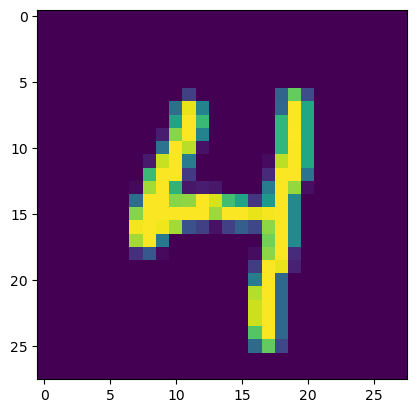

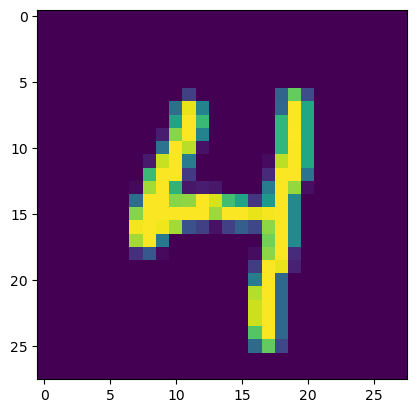

answer: 
4
[0 0 0 0 1 0 0 0 0 0]
prediction: 
4
[0.07639688120253448, 0.0008874460907419175, 0.02256090866405577, 0.02466462081635835, 0.8754694257912786, 0.1110211601983119, 0.0668192790805861, 0.01956169983080034, 0.07004965695205298, 0.49295059551283504]


In [49]:
print("picture: ")

fig, ax = plt.subplots()
im = ax.imshow(row_to_matrix(X_test[test_example_idx]))
plt.show()

fig, ax = plt.subplots()
im = ax.imshow(x_test[test_example_idx])
plt.show()

print("answer: ")
print(y_test[test_example_idx])
print(Y_test[test_example_idx])

print("prediction: ")
model.predict(X_test[test_example_idx])
print(model.activationsL[1].index(max(model.activationsL[1])))
print(model.activationsL[1])

# Get predictions on test data

In [50]:
predictions = []
for i in range(len(X_test)):
    model.predict(X_test[i])
    p = model.activationsL[1].index(max(model.activationsL[1]))
    predictions.append(p)
    print(*[i+1, y_test[i], p])
predictions = np.array(predictions)

1 7 7
2 2 2
3 1 1
4 0 0
5 4 4
6 1 1
7 4 4
8 9 9
9 5 4
10 9 9
11 0 0
12 6 6
13 9 9
14 0 0
15 1 1
16 5 5
17 9 9
18 7 7
19 3 3
20 4 4
21 9 9
22 6 6
23 6 6
24 5 5
25 4 4
26 0 0
27 7 7
28 4 4
29 0 0
30 1 1
31 3 3
32 1 1
33 3 3
34 4 6
35 7 7
36 2 2
37 7 7
38 1 1
39 2 3
40 1 1
41 1 1
42 7 7
43 4 4
44 2 2
45 3 3
46 5 5
47 1 3
48 2 2
49 4 4
50 4 4
51 6 6
52 3 3
53 5 5
54 5 5
55 6 6
56 0 0
57 4 4
58 1 1
59 9 9
60 5 5
61 7 7
62 8 8
63 9 9
64 3 2
65 7 7
66 4 4
67 6 6
68 4 4
69 3 3
70 0 0
71 7 7
72 0 0
73 2 2
74 9 7
75 1 1
76 7 7
77 3 3
78 2 7
79 9 9
80 7 7
81 7 9
82 6 6
83 2 2
84 7 7
85 8 5
86 4 4
87 7 7
88 3 3
89 6 6
90 1 1
91 3 3
92 6 6
93 9 8
94 3 3
95 1 1
96 4 4
97 1 1
98 7 1
99 6 6
100 9 9
101 6 6
102 0 0
103 5 5
104 4 4
105 9 9
106 9 9
107 2 2
108 1 1
109 9 9
110 4 4
111 8 8
112 7 1
113 3 3
114 9 9
115 7 7
116 4 9
117 4 4
118 4 4
119 9 9
120 2 2
121 5 5
122 4 6
123 7 7
124 6 6
125 7 4
126 9 9
127 0 2
128 5 5
129 8 8
130 5 5
131 6 6
132 6 6
133 5 5
134 7 7
135 8 8
136 1 1
137 0 0
138 1 1
139 

# Show metrics

In [51]:
error = y_test - predictions

In [52]:
RMSE = np.sqrt(np.mean(np.power(error, 2)))

In [53]:
N = y_test.shape[0]
accuracy = (y_test == predictions).sum() / N

In [54]:
print(f"RMSE = {RMSE} \n"
      f"Accuracy = {accuracy}")

RMSE = 1.5525140901131944 
Accuracy = 0.8674


# Extraction of the dumb generator (Penrose Pseudo Invers of the weights' matrix)

In [55]:
# M = np.array([[1,2,3],[2,0,1],[3,2,2]])
#
# print(M)
#
# N = np.linalg.pinv(M)
#
# print(N)
#
# print(M.dot(N))

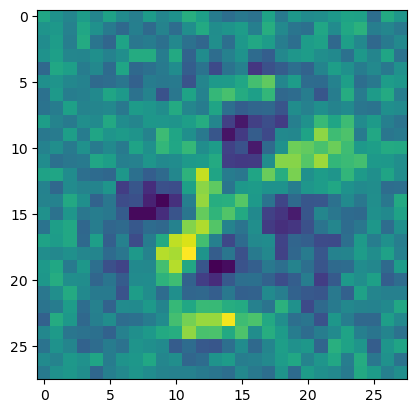

In [60]:
W = []
for j in range(len(model.NET[1])):
    w_L = []
    for k in range(len(model.NET[0])):
        w_L.append(model.NET[1][j].w[k][0])
    W.append(w_L)

W_revers = np.linalg.pinv(np.array(W))
one = np.array([0,0,0,0,0,0,0,0,1,0]).reshape((10,1))

digitOne = W_revers.dot(one)

def calamn_to_matrix(calamn):
    matrix = []
    k = 0
    one_row = []
    for i in range(len(calamn)):
        one_row.append(calamn[i][0])
        k += 1
        if k == 28:
            k = 0
            matrix.append(one_row)
            one_row = []
    return matrix

digitOneMatrix = calamn_to_matrix(digitOne)

fig, ax = plt.subplots()
im = ax.imshow(digitOneMatrix)
plt.show()
